In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [2]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.evaluation import *

from decode_fish.funcs.visualization import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

hydra.initialize()

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

## Generate Data for internal comparison

In [4]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_MOp"])
# cfg = OmegaConf.create(cfg)

In [5]:
thetas = 1.
channel_facs = [1.] * 22

cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled4_images151.tif'

cfg.genm.foci.n_foci_avg = 0

cfg.genm.prob_generator.low = 0.02
cfg.genm.prob_generator.high = 0.05

cfg.genm.PSF.n_cols = 1
cfg.genm.microscope.ch_cols = [0] * 22

cfg.genm.noise.theta = thetas
cfg.genm.microscope.ch_facs = channel_facs
cfg.genm.microscope.col_shifts_enabled = False

cfg.sim.roi_mask.percentile = 20
cfg.sim.random_crop.crop_sz = 512

cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.bg_estimation.type = 'smoothing'

cfg.genm.intensity_dist.int_conc = 5
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = 1.

cfg.genm.microscope.scale = 10000
cfg.genm.phasing = 0.0
cfg.sim.bg_estimation.fractal.scale = 0

cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf_onesided_normed.tif'
cfg.genm.microscope.norm = 'none'
cfg.genm.PSF.mode = 'bicubic'

cfg.genm.emitter_noise.rate_fac = 3.

cfg.network.is_2D = True

In [6]:
psf, noise, micro = load_psf_noise_micro(cfg)

In [7]:
state_dict = micro.state_dict()
ch_shifts = torch.randn(micro.channel_shifts.shape) * 0.15
ch_shifts[:,2] *= 0.
state_dict['channel_shifts'] = ch_shifts
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [8]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_6_os/'
# !mkdir '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_6_os/'

In [9]:
cfg.training.bs = 1
_, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 512, 512)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)
sim_codebook = expand_codebook(codebook) 

In [11]:
# from decode_fish.funcs.routines import *
# from decode_fish.engine.point_process import *
# from decode_fish.engine.microscope import *
# from decode_fish.funcs.output_trafo import sample_to_df

# def sim_data(decode_dl, micro, batches, int_conc=4., int_rate=1., int_loc=.5, channels=1, n_bits=1, codebook=None, rate_fac=1., pos_noise_xy=0., pos_noise_z=0., 
#              emitter_noise_rate_fac=0, emitter_noise_int_fac=0, const_theta_sim=True, int_option=1):
    
#     gt_dfs = []
#     xsim_col = []
#     cols_col = []
#     bg_col = []

#     for _ in range(batches):
#         with torch.no_grad():
#             ret_dict = next(iter(decode_dl))
#             x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
#             if micro.col_shifts_enabled:
#                 zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
#                 zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
#             else:
#                 zcrop, ycrop, xcrop, colshift_crop = None, None, None, None
                
#             background = background * micro.get_ch_mult()
#             local_rate *= rate_fac
            
#             sim_vars = PointProcessUniform(local_rate[:,0], int_conc, int_rate, int_loc, channels=channels, n_bits=n_bits, sim_z=micro.slice_rec, codebook=codebook, int_option=int_option).sample(from_code_book=(codebook is not None))
#             ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
#             if pos_noise_xy or pos_noise_z:
#                 ch_inp[1:4] = add_pos_noise(ch_inp[1:4], [pos_noise_xy, pos_noise_xy, pos_noise_z], n_bits)
#             xsim = micro(*ch_inp, add_noise=True)

#             if emitter_noise_rate_fac:
#                 noise_vars = PointProcessUniform(local_rate[:,0] * emitter_noise_rate_fac, int_conc=int_conc * emitter_noise_int_fac, 
#                                                int_rate=int_rate, int_loc=int_loc, 
#                                                sim_iters=5, channels=channels, n_bits=1, 
#                                                sim_z=micro.slice_rec, codebook=None, int_option=int_option).sample(from_code_book=False)     

#                 noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop, xcrop=xcrop)
#                 background += micro(*noise_inp, add_noise=True)
        
#             x = micro.noise(xsim, background, const_theta_sim=const_theta_sim).sample()

#             if micro.col_shifts_enabled:
#                 colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, decode_dl.dataset.dataset_tfms[0].crop_sz[-1])
#                 net_inp = torch.concat([x,colshift_crop], 1)
#                 cols_col.append(colshift_crop)
                
#             xsim_col.append(x)
#             bg_col.append(background)

#             gt_vars = sim_vars[:-2] 
#             gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
#             gt_dfs.append(gt_df)
        
#     cols_col = torch.cat(cols_col) if micro.col_shifts_enabled else None
        
#     return torch.cat(xsim_col), torch.cat(bg_col), cols_col, cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

In [12]:
# xsim, bg, cols, gt_df = sim_data(decode_dl, micro, 10, 
#                           int_conc=cfg.genm.intensity_dist.int_conc, int_rate=cfg.genm.intensity_dist.int_rate, int_loc=cfg.genm.intensity_dist.int_loc,
#                           channels=22, n_bits=4, codebook=torch.tensor(codebook), rate_fac=1., 
#                           pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z, 
#                           emitter_noise_rate_fac=cfg.genm.emitter_noise.rate_fac, emitter_noise_int_fac=cfg.genm.emitter_noise.int_fac
#                          )

# gt_df = px_to_nm(gt_df)
# gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100])

In [13]:
from decode_fish.engine.point_process import *

code_weight = torch.ones(len(sim_codebook))
code_weight[len(codebook):] *= cfg.genm.emitter_noise.rate_fac
point_process = PointProcessUniform(int_conc=cfg.genm.intensity_dist.int_conc, int_rate=cfg.genm.intensity_dist.int_rate, int_loc=cfg.genm.intensity_dist.int_loc, 
                                   sim_iters=5, n_channels=cfg.genm.exp_type.n_channels, sim_z=cfg.genm.exp_type.pred_z, slice_rec=cfg.genm.exp_type.slice_rec, 
                                   codebook=sim_codebook, int_option=cfg.training.int_option, code_weight=code_weight)

In [14]:
xsim, cols, gt = sim_data(decode_dl, micro, point_process, 10, n_codes=len(codebook), rate_fac=1., pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z)

In [15]:
gt = px_to_nm(gt)
gt = exclude_borders(gt, border_size_zyx=[0,500,500], img_size=[cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100])

In [16]:
channel_facs = torch.randn(micro.channel_facs.shape) * 0.15 + 1

In [17]:
xsim = xsim / channel_facs[None,:,None,None,None].cuda()

In [18]:
state_dict = micro.state_dict()
state_dict['channel_facs'] = channel_facs
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
torch.save(micro.state_dict(), out_dir+'microscope.pkl')

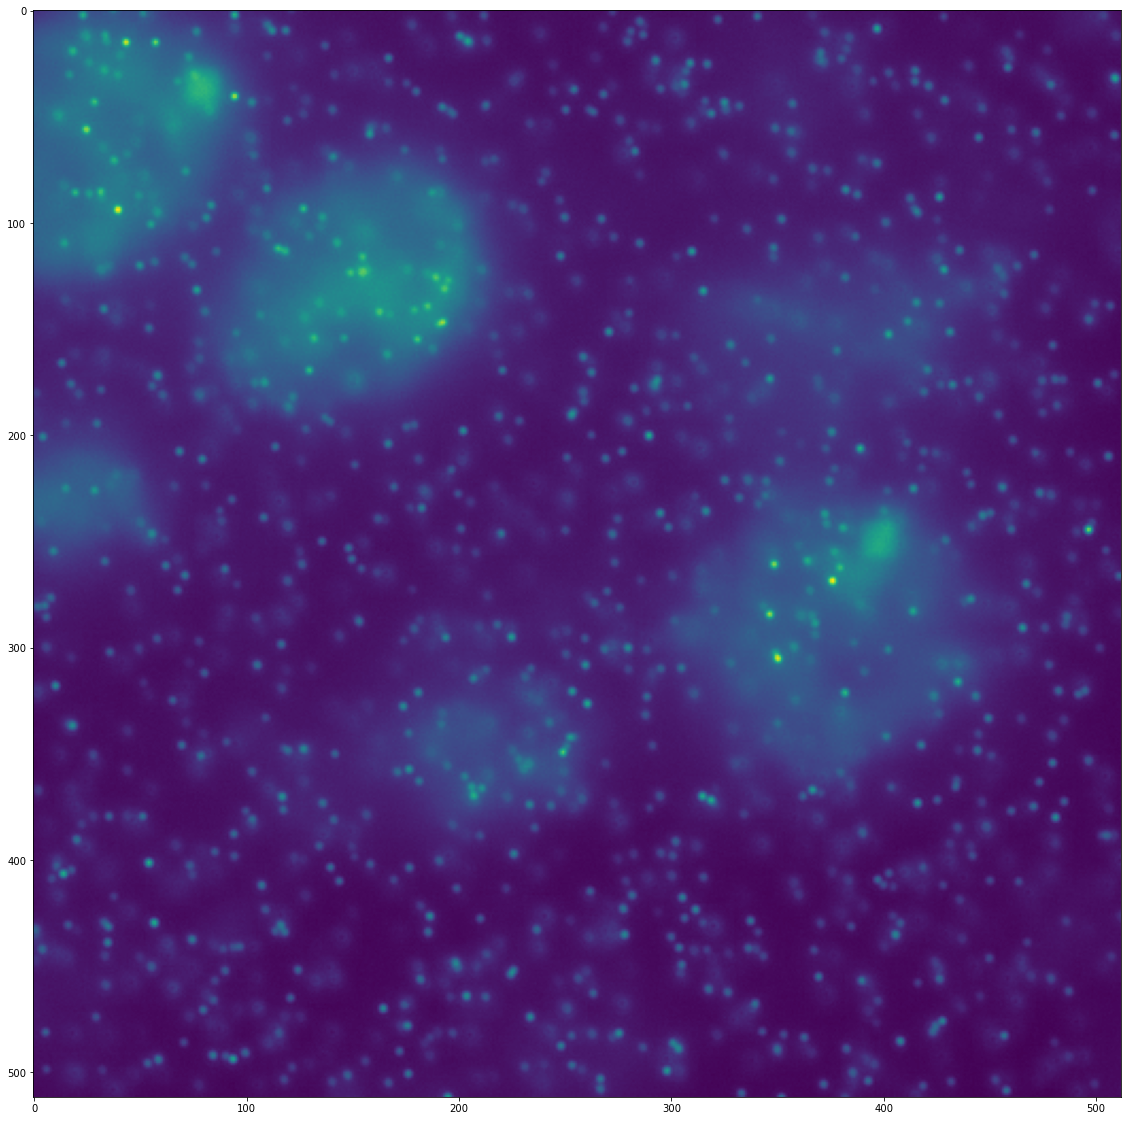

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(cpu(xsim[4,11,0]))

In [21]:
with h5py.File(out_dir+'images.h5', 'w') as f:
    
    add_df_to_hdf5(f, 'locations', gt)          
    f.create_dataset('frames', data=cpu(xsim))

import tifffile
tifffile.imsave(out_dir+'images.tiff', data=cpu(xsim))

In [251]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_6_os/'
with h5py.File(out_dir+'images.h5', 'r') as f:
    
    gt_df = get_df_from_hdf5(f['locations'])  
    frames = f['frames'][()]

In [290]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_6_os/ae_train////train.yaml')
cfg.genm.PSF.psf_extent_zyx=11

In [257]:
cfg_files = glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_6_os/*/train.yaml')

In [56]:
cfg_files = [
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/sl_no_learn/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/ae_train_noembgp/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_5_osc/sl_true_gen_noembgp/train.yaml']

In [258]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [260]:
cfg.genm.PSF.psf_extent_zyx = [7,21,21]

In [291]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
# psf_init = cpu(micro.psf_init_vol)
post_proc.codebook = torch.tensor(codebook)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
10 volumes


0.9974824671394682
0.9799931361615318
0.9919285554978848
nan


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


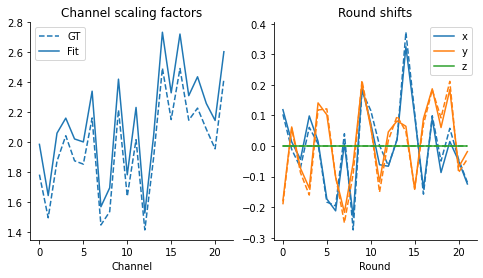

In [264]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8, 4))
cmap = sns.color_palette("tab10")

ax1.plot(cpu(micro_init.channel_facs), color=cmap[0], linestyle='--', label='GT')
ax1.plot(cpu(micro.channel_facs), color=cmap[0], label='Fit')
ax1.set_title('Channel scaling factors')
ax1.set_xlabel('Channel')
ax1.legend()
print(np.corrcoef(cpu(micro.channel_facs), cpu(micro_init.channel_facs))[0,1])

labels = ['x','y','z']
for i in range(3):
    ax2.plot(cpu(micro.channel_shifts[:,i]), label=labels[i], color=cmap[i])
    ax2.plot(cpu(micro_init.channel_shifts[:,i] - micro_init.channel_shifts[:,i].mean()), linestyle='--', color=cmap[i])
    print(np.corrcoef(cpu(micro.channel_shifts[:,i]), cpu(micro_init.channel_shifts[:,i]))[0,1])
ax2.set_title('Round shifts')
ax2.set_xlabel('Round')
plt.legend()
sns.despine()

In [51]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf_onesided_normed.tif')

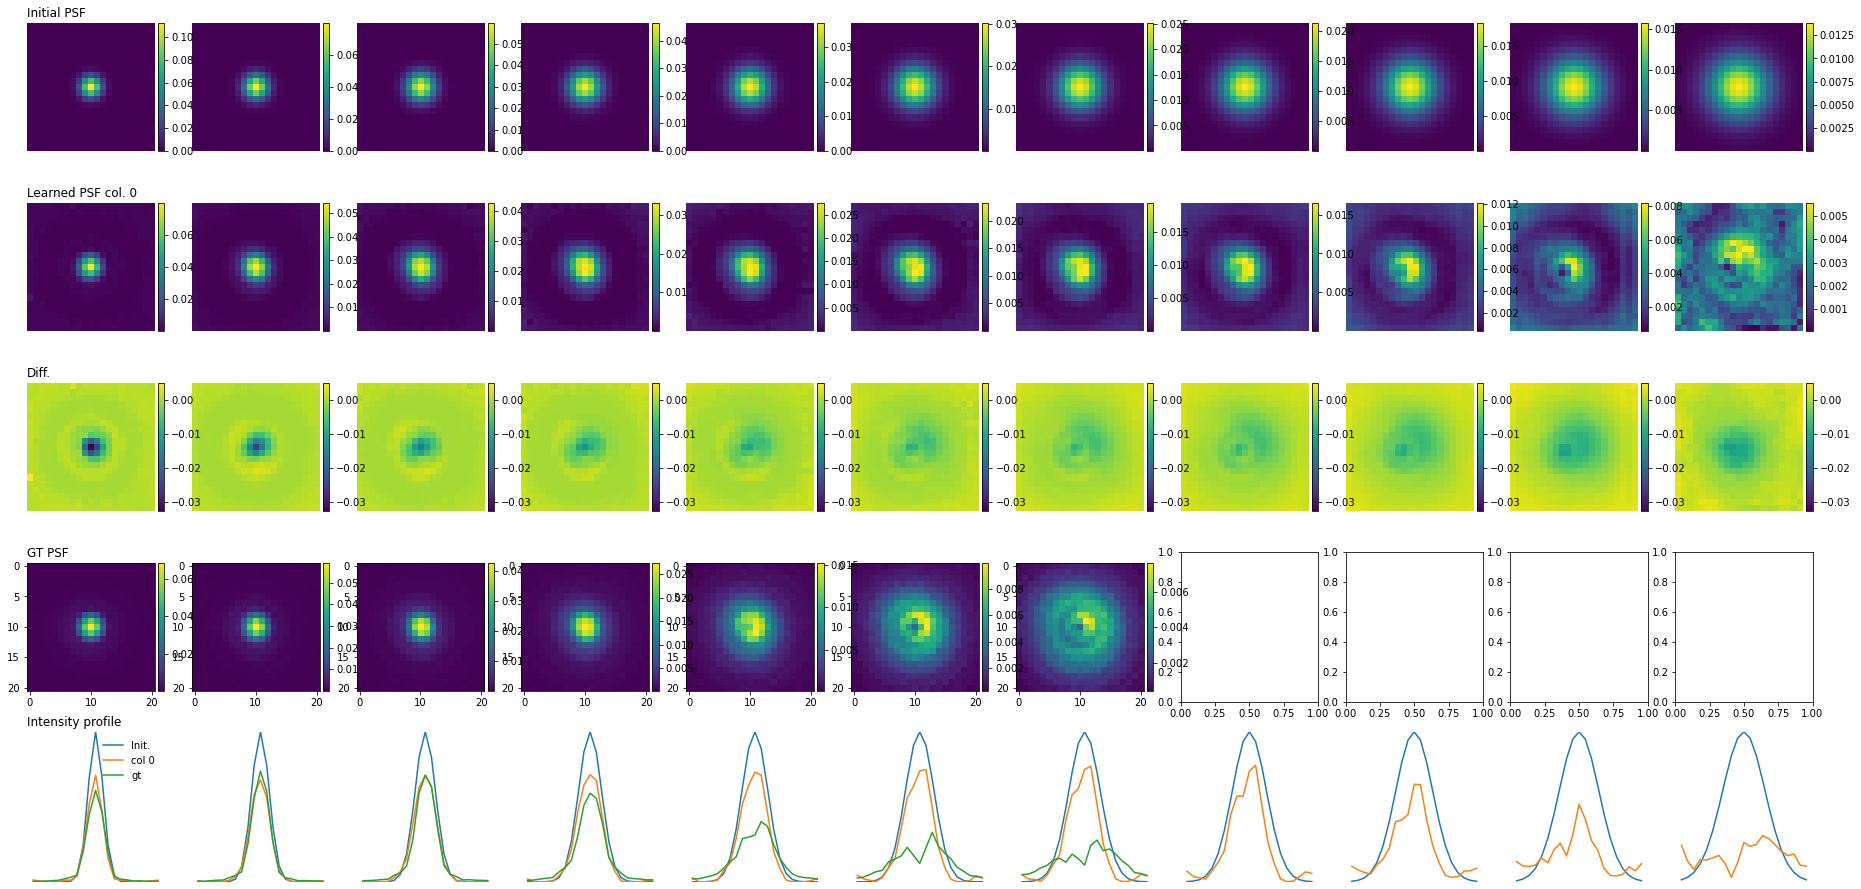

In [265]:
plot_slice_psf_pars(psf_vol, micro.psf_init_vol, gt_psf[None], normed=True)

In [266]:
from decode_fish.funcs.predict import window_predict
df_dict = {}
for file in [cfg_files[i] for i in range(len(cfg_files))]:
    k = file.split('/')[-2]
    print(k)
#     if k not in df_dict:
    cfg = OmegaConf.load(file)
    if 'true' not in k:
        cfg.genm.PSF.psf_extent_zyx=11
    model = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl').cuda()
    psf, noise, micro = load_psf_noise_micro(cfg)
    
    micro.load_state_dict(torch.load(Path(cfg.output.save_dir)/'microscope.pkl'), strict=False)
    res_df = window_predict(model, post_proc, torch.tensor(frames), window_size=[None, 128, 128], device='cuda', chrom_map=None, scale=micro.get_ch_mult(), progress_bar=True)
    res_df = exclude_borders(res_df, border_size_zyx=[0,500,500], img_size=[512*100,512*100,512*100])  
    df_dict[k] = res_df

ae_train
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.21s/it]


sl_no_learn
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.88s/it]


sl_true_gen
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.89s/it]


In [267]:
for k in df_dict:
    int_arr = zero_int_ch(df_dict[k].nsmallest(15000, 'comb_sig'), codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
    ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
    print(k, np.sqrt(np.var(ch_means)))
    
    plt.plot(ch_means/np.mean(ch_means), label=k)
plt.plot(1/channel_facs, color='black')
plt.legend()

IndexError: index 273 is out of bounds for axis 0 with size 252

In [283]:
int_arr = zero_int_ch(df_dict['ae_train'].nsmallest(15000, 'comb_sig'), codebook)[[f'int_{i}' for i in range(codebook.shape[1])]].values
ch_means = [int_arr[:,i].sum()/(int_arr[:,i] != 0).sum() for i in range(22)]
print(k, np.sqrt(np.var(ch_means)))

sl_nolearn 0.18554928866803166


In [59]:
for k in df_dict.keys():
    print(k, len(df_dict[k]))

sl_no_learn 29578
ae_train_noembgp 51270
sl_true_gen_noembgp 58088


In [315]:
perf_df = pd.DataFrame()
match_dict = {}

for k in df_dict.keys():
    print(k)
    
    gt_genes = gt_df[gt_df['code_inds']<len(codebook)]
    df_dict[k] = df_dict[k][df_dict[k]['code_inds']<len(codebook)]
    
    perf, matches, _ = matching(gt_df, df_dict[k], print_res=True, tolerance=500, ignore_z=True)
    df_dict[k].loc[:, 'class'] = 1
    df_dict[k].loc[df_dict[k]['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0    
    
    perf_df[k] = pd.Series(perf)
    match_dict[k] = matches

ae_train
Recall: 0.610
Precision: 0.912
Jaccard: 57.554
RMSE_vol: 69.543
Eff_3d: 45.130
FN: 31266.0 FP: 4724.0
Num. matches: 48801.000
Shift: -37.60,15.92,40.55
sl_no_learn
Recall: 0.565
Precision: 0.921
Jaccard: 53.893
RMSE_vol: 67.488
Eff_3d: 42.864
FN: 34821.0 FP: 3888.0
Num. matches: 45246.000
Shift: -28.91,11.62,45.87
sl_true_gen
Recall: 0.676
Precision: 0.825
Jaccard: 59.112
RMSE_vol: 37.259
Eff_3d: 55.068
FN: 25940.0 FP: 11500.0
Num. matches: 54127.000
Shift: -4.56,1.73,10.27


/tmp/ipykernel_43480/2262223275.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[k].loc[:, 'class'] = 1


In [269]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

keys = ['comb_sig','int_ratio','z']

for k in df_dict.keys():
    dfc = sel_int_ch(df_dict[k], codebook)
    X = np.concatenate([dfc[keys].values])
    y = np.concatenate([dfc['class'].values])

    clf = LogisticRegression(random_state=1,max_iter=10000, class_weight='balanced').fit(X, y)
    
    df_dict[k]['score'] = clf.predict_proba(X)[:,1]

IndexError: index 252 is out of bounds for axis 0 with size 252

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(131)
for k in df_dict:    
    df_c = df_dict[k].copy()
    df_c = sel_int_ch(df_c, codebook)
    r  = make_roc(df_c, 'comb_sig', n_max=40000, ascending=True)
    plt.plot(r[0],r[1], label=k)

plt.legend()
plt.ylim(0,1000)

plt.subplot(132)
for k in df_dict:    
    df_c = df_dict[k].copy()
    df_c = sel_int_ch(df_c, codebook)
    r  = make_roc(df_c, 'int_ratio', n_max=40000, ascending=True)
    plt.plot(r[0],r[1], label=k)

plt.legend()
plt.ylim(0,1000)

# plt.subplot(133)
# for k in df_dict:    
#     df_c = df_dict[k].copy()
#     df_c = sel_int_ch(df_c, codebook)
#     r  = make_roc(df_c, 'score', n_max=40000, ascending=True)
#     plt.plot(r[0],r[1], label=k)

# plt.legend()
# plt.ylim(0,1000)

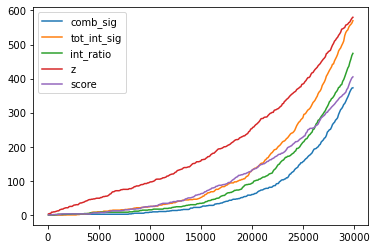

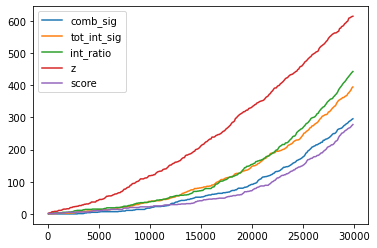

In [541]:
df_c = sel_int_ch(df_dict['ae_train_l1'], codebook)

for k in ['comb_sig','tot_int_sig', 'int_ratio', 'z','score']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(df_c, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
    
plt.legend()
plt.show()
df_c = sel_int_ch(df_dict['sl_true_gen_mae'], codebook)

for k in ['comb_sig','tot_int_sig', 'int_ratio', 'z','score']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(df_c, k, n_max=30000, ascending=b)
    plt.plot(r[0],r[1], label=k)
    
plt.legend()

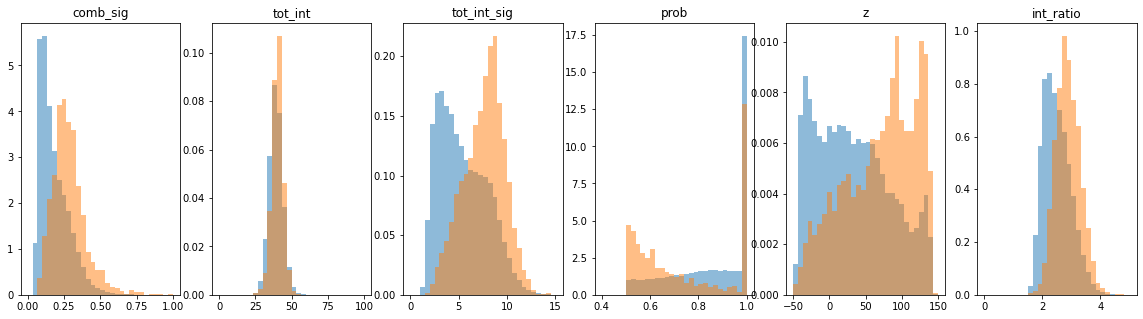

In [517]:
cdf = sel_int_ch(df_dict['sl_true_gen_mae'], codebook)

metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.,31), np.linspace(0,100,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,5., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(cdf[cdf['class'] == 0][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(cdf[cdf['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

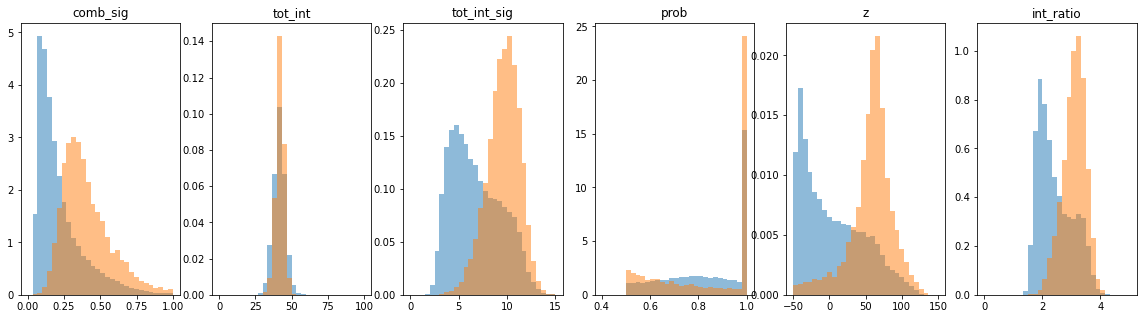

In [519]:
cdf = sel_int_ch(df_dict['ae_train_l1'], codebook)

metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.,31), np.linspace(0,100,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,5., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(cdf[cdf['class'] == 0][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(cdf[cdf['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [53]:
# from decode_fish.funcs.routines import *
from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, micro, 5, 
                          int_conc=model.int_dist.int_conc.detach(), int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(),
                          channels=22, n_bits=4, codebook=torch.tensor(codebook), rate_fac=1., 
                          pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z, 
                          emitter_noise_rate_fac=cfg.genm.emitter_noise.rate_fac, emitter_noise_int_fac=cfg.genm.emitter_noise.int_fac
                         )

In [54]:
pred_dfs = []
net_inp = torch.concat([xsim], 1)
for i in range(len(net_inp)):
    pred_df = get_prediction(model, net_inp[i:i+1], post_proc, cuda=True)
    pred_dfs.append(pred_df)

pred_df = cat_emitter_dfs(pred_dfs)

In [55]:
perf, matches, _ = matching(px_to_nm(gt, cfg.evaluation.px_size_zyx), pred_df, tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.402
Precision: 0.903
Jaccard: 38.582
RMSE_vol: 63.369
Eff_3d: 30.891
FN: 3281.0 FP: 237.0
Num. matches: 2210.000
Shift: 0.80,0.19,-1.13


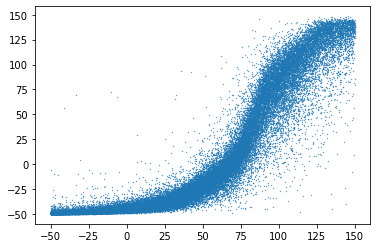

In [272]:
plt.scatter(match_dict['ae_train']['z_tar'], match_dict['ae_train']['z_pred'], s=0.1)

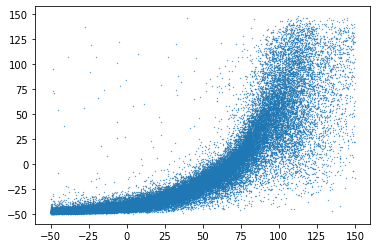

In [273]:
plt.scatter(match_dict['sl_no_learn']['z_tar'], match_dict['sl_no_learn']['z_pred'], s=0.1)

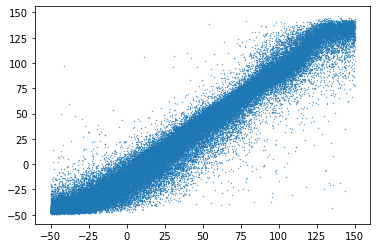

In [274]:
plt.scatter(match_dict['sl_true_gen']['z_tar'], match_dict['sl_true_gen']['z_pred'], s=0.1)

In [ ]:
# res_single = sel_int_ch(res_single, codebook)
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,3., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_single[~res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_single[res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

(array([5432., 5244., 4836., 4115., 3450., 2824., 2030., 1247.,  145.,
           9.]),
 array([-49.99455261, -30.79353333, -11.59251404,   7.60850525,
         26.80952454,  46.01054382,  65.21156311,  84.4125824 ,
        103.61360168, 122.81462097, 142.01564026]),
 <BarContainer object of 10 artists>)

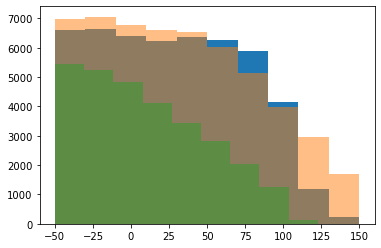

In [495]:
plt.hist(match_dict['ae_train_mae']['z_tar'])
plt.hist(match_dict['sl_true_gen_mae']['z_tar'],alpha=0.5)
plt.hist(match_dict['sl_no_learn']['z_tar'],alpha=0.5)

In [577]:
perf, matches, _ = matching(df_dict['ae_train_l1'], df_dict['sl_true_gen_mae'], print_res=True, tolerance=500, ignore_z=True)

Recall: 0.796
Precision: 0.848
Jaccard: 69.696
RMSE_vol: 51.201
Eff_3d: 60.330
FN: 12160.0 FP: 8524.0
Num. matches: 47572.000
Shift: 28.43,-11.02,-26.02


Text(0.5, 0, 'z GT')

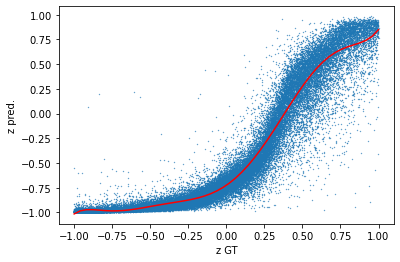

In [314]:
# get x and y vectors
x = (match_dict['ae_train']['z_tar'].values - 50)/100
y = (match_dict['ae_train']['z_pred'].values - 50)/100

# calculate polynomial
z = np.polyfit(x, y, 8)
f = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(-1, 1., 50)
y_new = f(x_new)

plt.scatter(x, y, s=0.1)
plt.plot(x_new, y_new, color='red')
plt.ylabel('z pred.')
plt.xlabel('z GT')

In [288]:
from decode_fish.engine.psf import LinearInterpolatedPSF

psf_gt = LinearInterpolatedPSF([7,21,21], n_cols=1, mode='bicubic')
psf_gt = swap_psf_vol(psf_gt, gt_psf)

In [292]:
psf_l = LinearInterpolatedPSF([11,21,21], n_cols=1, mode='bicubic')
psf_l = swap_psf_vol(psf_l, cpu(micro.psf.psf_volume[0]))
psf_ini = LinearInterpolatedPSF([11,21,21], n_cols=1, mode='bicubic')
psf_ini = swap_psf_vol(psf_ini, cpu(micro.psf_init_vol[0]))

In [305]:
zgt = torch.linspace(-1, 1., 100)
zgts = torch.clamp(0.5*zgt,-0.49999,0.49999) + 0.5 # transform to [0,1]
z_scaled = zgts * (7 - 2) # [0, z_size]
z_inds = (torch.div(z_scaled, 1, rounding_mode='trunc')).type(torch.cuda.LongTensor) + 1
z_os = -(z_scaled%1.) + 0.5
z_os = z_os.cuda()
z_inds = z_inds.cuda()

In [306]:
gt_stack = psf_gt.forward(z_os*0, z_os*0, z_os, z_inds, None)
gt_stack /= gt_stack.sum(dim=[3,4], keepdim=True)

In [307]:
# zl = torch.linspace(-1, 1, 100)
zl = torch.tensor(f(zgt))
zls = torch.clamp(0.5*zl,-0.49999,0.49999) + 0.5 # transform to [0,1]
z_scaled = zls * (11 - 2) # [0, z_size]
z_inds = (torch.div(z_scaled, 1, rounding_mode='trunc')).type(torch.cuda.LongTensor) + 1
z_os = -(z_scaled%1.) + 0.5
z_os = z_os.cuda()
z_inds = z_inds.cuda()

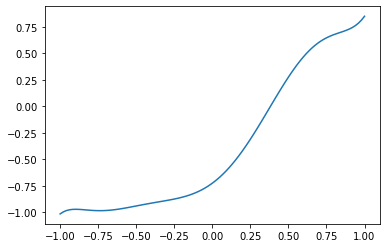

In [308]:
plt.plot(zgt,zl)

In [309]:
l_stack = psf_l.forward(z_os*0, z_os*0, z_os, z_inds, None)
l_stack /= l_stack.sum(dim=[3,4], keepdim=True)
ini_stack = psf_ini.forward(z_os*0, z_os*0, z_os, z_inds, None)
ini_stack /= ini_stack.sum(dim=[3,4], keepdim=True)

In [310]:
def plot_slice_psf_pars(psf_vol, psf_init, gt_psf=None, normed=False, figsize=[32,16]):
    
    psf_vol = np.array(abs(cpu(psf_vol)))
    psf_init = np.array(abs(cpu(psf_init)))
    gt_psf = np.array(abs(cpu(gt_psf)))
    
    n_cols = len(psf_vol)
    
    if normed:
        psf_vol /= psf_vol.sum(-1).sum(-1)[...,None,None]
        psf_init /= psf_init.sum(-1).sum(-1)[...,None,None]
    
    psf_diff = psf_vol - psf_init
    n_sl = psf_init.shape[1]
    mid_px = psf_init.shape[-1]//2

    f, axes = plt.subplots(2 + 2 * n_cols + (1 if gt_psf is not None else 0), n_sl, sharey=False, figsize=figsize)
    
    for z in range(n_sl):

        vmax_z = psf_vol[0:,z].max()
        im = axes[0,z].imshow(psf_init[0,z], vmax=None)
        add_colorbar(im)
        axes[0,z].set_axis_off()
        axes[0,z].margins(x=0, y=0, tight=True)

        mlist = [psf_init[:,z].max().item(), psf_vol[:,z].max().item()]
        plt_lim = np.max(mlist)
        
        axes[-1, z].plot(psf_init[0,z,mid_px], label='Init.')
        axes[-1, z].set_axis_off()
        axes[-1, z].set_ylim(0,plt_lim)

        for n in range(n_cols):

            im = axes[1+2*n,z].imshow(psf_vol[n,z], vmax=None)
            add_colorbar(im)
            axes[1+2*n,z].set_axis_off()
            axes[1+2*n,z].margins(x=0, y=0, tight=True)

            im = axes[2+2*n,z].imshow(psf_diff[n,z], vmax=psf_diff.max(), vmin=psf_diff.min())
            add_colorbar(im)
            axes[2+2*n,z].set_axis_off()
            axes[2+2*n,z].margins(x=0, y=0, tight=True)

            axes[-1, z].plot(psf_vol[n,z,mid_px], label=f'col {n}')
            
        if gt_psf is not None:
            
            if z < len(gt_psf[0]):
                im = axes[-2, z].imshow(gt_psf[n,z], vmax=None)
                add_colorbar(im)
                axes[-1, z].plot(gt_psf[n,z,mid_px], label='gt')

    axes[-1, 0].legend(frameon=False)
    axes[0,0].set_title('Initial PSF', loc='left')
    axes[-1,0].set_title(f'Intensity profile', loc='left')
    
    for n in range(n_cols):
        axes[1+2*n,0].set_title(f'Learned PSF col. {n}', loc='left')
        axes[2+2*n,0].set_title(f'Diff.', loc='left')
        
    if gt_psf is not None:
        axes[-2,0].set_title('GT PSF', loc='left')

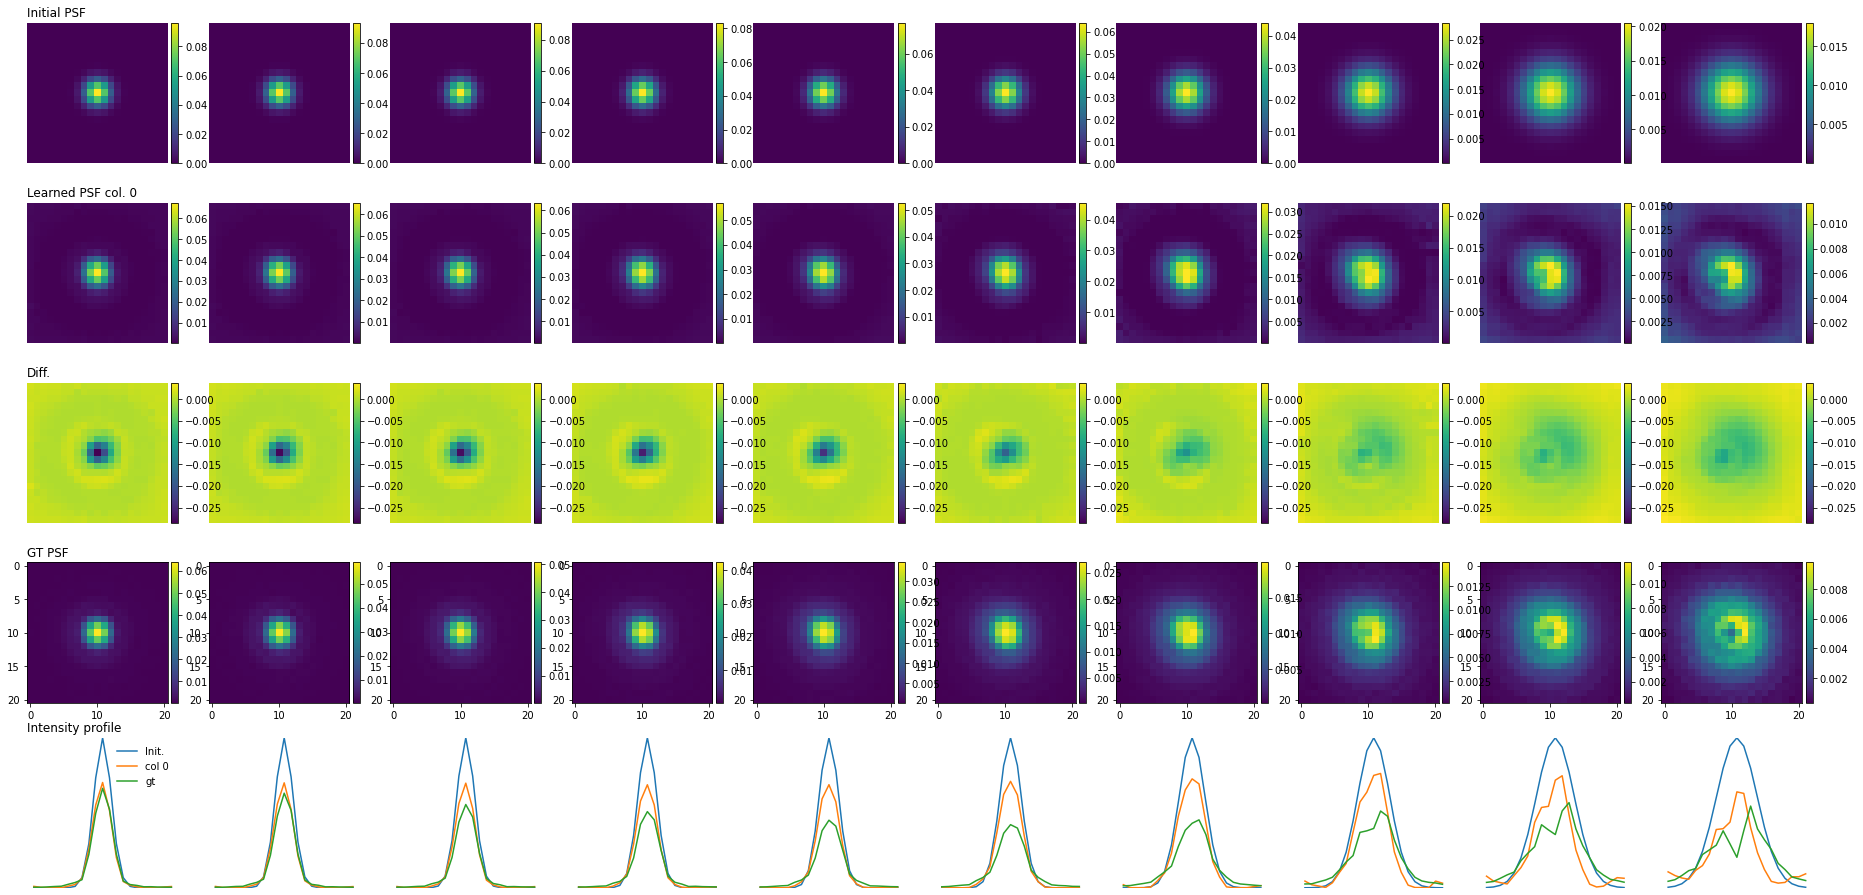

In [311]:
plot_slice_psf_pars(l_stack[::10,0,0][None], ini_stack[::10,0,0][None], gt_stack[::10,0,0][None], normed=True)

In [90]:
micro.psf_init_vol.shape

torch.Size([1, 11, 21, 21])